### Prédiction Météorologique Par analyse numérique et séries temporelles
Réalisé par :
Hany El Atlassi;
Salwa Khattami;
El Yakeni Mohammed Amine

### Première étape
#### Data Preprocessing

Le preprocessing consiste en la préparation des données pour leur utilisation lors du modèle d'apprentissage automatique. Il s'assure que les données soient nettoyées, classifiées et normalisées

In [1]:
# On commence par importer les librairies dont on aura besoin
import tensorflow as tf # Librairie de deep learning
import pandas as pd # Librairie de manipulation de données
import numpy as np # Librairie de calcul scientifique
import matplotlib.pyplot as plt # Librairie d'affichage de graphiques
import os # Librairie pour les fonctions système

Nous utilisons "jena_climate_dataset" comme données, alors on l'extrait et on le lit avec pandas

In [2]:
zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',fname='jena_climate_2009_2016.csv.zip', extract=True)
csv_path,_= os.path.splitext(zip_path)
starter_df = pd.read_csv(csv_path)
starter_df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


Notre Dataset est de taille (420551,15).

On passe à vérifier l'existence de valeurs inexistantes (null values). Quand une valeur n’existe pas (et non pas égale à 0), la taille du array contenant les données change. Cette étape est cruciale puisque nôtre modèle exécute des calculs de produits matriciels (durant la descente de gradient, et entre les paramètres W et nos données X), ainsi la taille de ces matrices doit être correcte et exacte. 

In [3]:
starter_df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

Le dataset n'a aucune valeure inexistante, et les données sont toutes numériques.

In [4]:
starter_df['Date Time'] = pd.to_datetime(starter_df['Date Time'],format="%d.%m.%Y %H:%M:%S")
starter_df.set_index(starter_df['Date Time'],inplace=True)
#On change l'index du dataframe pour qu'il soit la colonne 'Date Time', afin que le modèle puisse utiliser les dates comme données d'entrée

Passons à l'ingénierie des caractéristiques, nous allons traiter 3 données principales: La température, la pression et l'humidité. 

In [5]:
df = starter_df[['p (mbar)','T (degC)','sh (g/kg)']]

In [6]:
df

,p (mbar),T (degC),sh (g/kg)
Date Time,,,
2009-01-01 00:10:00,996.52,-8.02,1.94
2009-01-01 00:20:00,996.57,-8.41,1.89
2009-01-01 00:30:00,996.53,-8.51,1.88
2009-01-01 00:40:00,996.51,-8.31,1.92
2009-01-01 00:50:00,996.51,-8.27,1.92
...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,2.06
2016-12-31 23:30:00,999.93,-3.35,2.07
2016-12-31 23:40:00,999.82,-3.16,2.05


La dernière étape du traitement de données est la normalisation des données. On remarque que les données de la température varient entre des valeurs de -15 et 35, l'humidité entre 1 et 3, mais la pression entre 900 et 1100. Le modèle intuitivement donnera de l'importance aux données de la pression (Durant le calcul les données de la pression étant grandes affecteront l'efficacité du modèle, il y aura un bias). Pour but d'éviter cela on normalise les données de sorte à ce qu'elles soient toutes entre 0 et 1.

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns,index=df.index)

p (mbar)


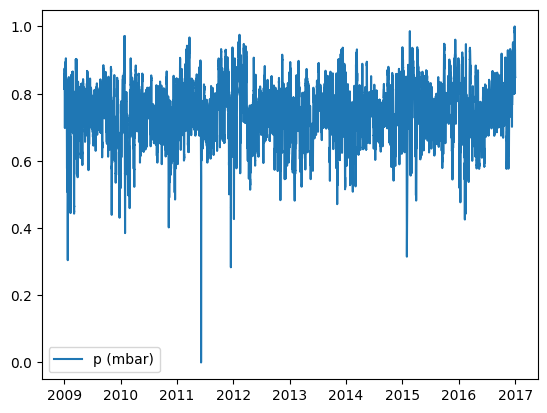

T (degC)


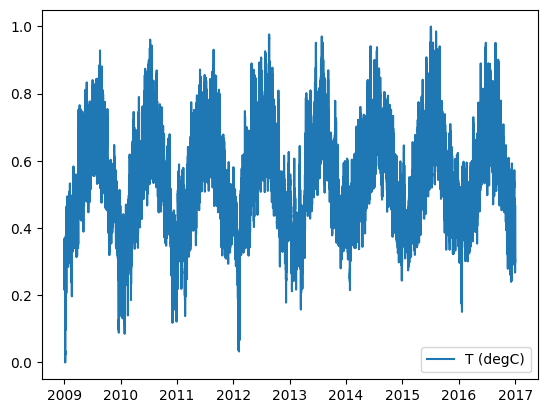

sh (g/kg)


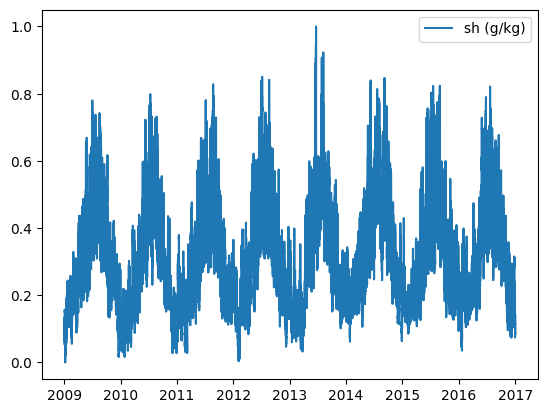

In [8]:
for i in df.columns:
    print(i)
    plt.plot(df[i],label=i)
    plt.legend()
    plt.show()

Les graphes ci-dessus représentent la distribution des données dans le dataset

### Deuxième étape

La specifité des séries temporelles est leur dimension. Les données classiques sont sous forme (N x D, N: number of ids/data; D: Features/caractéristiques) de 2 dimensions, pourtant, les séries temporelles ne sont pas constante dans le temps, donc de forme (N x T x D, T: l'instant dans le temps)

La prédiction se fera comme suit: le modèle lit séquentiellement 7 valeurs de température, et prédit la valeur qui les suit. L'entré de notre programme doit etre sous forme de [X1,X2,X3,X4,X5,X6,X7].

In [9]:
T = 7
X = []
Y = []
for i in range(len(df)-T):
    X.append(df[i:i+T])
    Y.append(df[i+T:i+T+1])

X,y = np.array(X),np.array(Y)
y = y.reshape(-1,3)
X.shape,y.shape

((420544, 7, 3), (420544, 3))

On départage le dataset en trois parties: Training data, Validation data and Testing data

En notant le volume de notre dataset, on se décide sur cette répartition (95%,5%,5%)

In [10]:
X_train,X_val,X_test = X[:int(len(df)*0.9)],X[int(len(df)*0.9):int(len(df)*0.95)],X[int(len(df)*0.95):]
y_train,y_val,y_test = y[:int(len(df)*0.9)],y[int(len(df)*0.9):int(len(df)*0.95)],y[int(len(df)*0.95):]
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((378495, 7, 3),
 (378495, 3),
 (21028, 7, 3),
 (21028, 3),
 (21021, 7, 3),
 (21021, 3))

Nous passons à la création du modèle d'apprentissage.

In [11]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [12]:
model  = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(8,'relu'))
model.add(Dense(3,'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 17955 (70.14 KB)
Trainable params: 17955 (70.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


la structure du modèle est claire, et on passe à son entrainement.
On précise les hyperparamètres (learning rate, l'optimiseur, les metriques d'erreur).

In [13]:
cp = ModelCheckpoint('model/',save_best_only=True)
model.compile(loss='mse',optimizer=Adam(0.0001), metrics=['mae'])

In [14]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,callbacks=[cp])

Epoch 1/20
11815/11828 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0149INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 47s 4ms/step - loss: 0.0020 - mae: 0.0148 - val_loss: 8.2386e-05 - val_mae: 0.0061
Epoch 2/20
11827/11828 [============================>.] - ETA: 0s - loss: 5.6307e-05 - mae: 0.0049INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 46s 4ms/step - loss: 5.6307e-05 - mae: 0.0049 - val_loss: 4.7604e-05 - val_mae: 0.0049
Epoch 3/20
11819/11828 [============================>.] - ETA: 0s - loss: 3.2500e-05 - mae: 0.0037INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 46s 4ms/step - loss: 3.2504e-05 - mae: 0.0037 - val_loss: 3.2805e-05 - val_mae: 0.0037
Epoch 4/20
11817/11828 [============================>.] - ETA: 0s - loss: 2.7049e-05 - mae: 0.0033INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 47s 4ms/step - loss: 2.7046e-05 - mae: 0.0033 - val_loss: 2.8029e-05 - val_mae: 0.0033
Epoch 5/20
11820/11828 [============================>.] - ETA: 0s - loss: 2.4629e-05 - mae: 0.0031INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 47s 4ms/step - loss: 2.4627e-05 - mae: 0.0031 - val_loss: 2.5727e-05 - val_mae: 0.0032
Epoch 6/20
11828/11828 [==============================] - 46s 4ms/step - loss: 2.2603e-05 - mae: 0.0030 - val_loss: 2.6078e-05 - val_mae: 0.0033
Epoch 7/20
11824/11828 [============================>.] - ETA: 0s - loss: 2.1050e-05 - mae: 0.0029INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 50s 4ms/step - loss: 2.1050e-05 - mae: 0.0029 - val_loss: 2.3951e-05 - val_mae: 0.0031
Epoch 8/20
11822/11828 [============================>.] - ETA: 0s - loss: 1.9799e-05 - mae: 0.0028INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 48s 4ms/step - loss: 1.9796e-05 - mae: 0.0028 - val_loss: 2.3108e-05 - val_mae: 0.0031
Epoch 9/20
11824/11828 [============================>.] - ETA: 0s - loss: 1.8760e-05 - mae: 0.0027INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 52s 4ms/step - loss: 1.8758e-05 - mae: 0.0027 - val_loss: 2.0865e-05 - val_mae: 0.0028
Epoch 10/20
11816/11828 [============================>.] - ETA: 0s - loss: 1.7899e-05 - mae: 0.0026INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 50s 4ms/step - loss: 1.7895e-05 - mae: 0.0026 - val_loss: 2.0688e-05 - val_mae: 0.0028
Epoch 11/20
11816/11828 [============================>.] - ETA: 0s - loss: 1.7173e-05 - mae: 0.0025INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 46s 4ms/step - loss: 1.7170e-05 - mae: 0.0025 - val_loss: 1.9648e-05 - val_mae: 0.0026
Epoch 12/20
11828/11828 [==============================] - 44s 4ms/step - loss: 1.6545e-05 - mae: 0.0025 - val_loss: 2.2013e-05 - val_mae: 0.0030
Epoch 13/20
11828/11828 [==============================] - 44s 4ms/step - loss: 1.5979e-05 - mae: 0.0024 - val_loss: 2.3433e-05 - val_mae: 0.0030
Epoch 14/20
11824/11828 [============================>.] - ETA: 0s - loss: 1.5546e-05 - mae: 0.0023INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 47s 4ms/step - loss: 1.5544e-05 - mae: 0.0023 - val_loss: 1.9203e-05 - val_mae: 0.0026
Epoch 15/20
11828/11828 [==============================] - 43s 4ms/step - loss: 1.5219e-05 - mae: 0.0023 - val_loss: 1.9564e-05 - val_mae: 0.0027
Epoch 16/20
11828/11828 [==============================] - 44s 4ms/step - loss: 1.4943e-05 - mae: 0.0022 - val_loss: 2.0219e-05 - val_mae: 0.0028
Epoch 17/20
11828/11828 [==============================] - 44s 4ms/step - loss: 1.4688e-05 - mae: 0.0022 - val_loss: 2.0220e-05 - val_mae: 0.0028
Epoch 18/20
11822/11828 [============================>.] - ETA: 0s - loss: 1.4543e-05 - mae: 0.0022INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


11828/11828 [==============================] - 48s 4ms/step - loss: 1.4542e-05 - mae: 0.0022 - val_loss: 1.8537e-05 - val_mae: 0.0026
Epoch 19/20
11828/11828 [==============================] - 42s 4ms/step - loss: 1.4395e-05 - mae: 0.0022 - val_loss: 1.9366e-05 - val_mae: 0.0026
Epoch 20/20
11828/11828 [==============================] - 42s 4ms/step - loss: 1.4232e-05 - mae: 0.0021 - val_loss: 1.8732e-05 - val_mae: 0.0025


In [15]:
model = load_model('model/') 
# grace a cp checkpoint on peut charger le meilleur modèle

La fonction ci-dessous permet de dessiner les graphes de la température, pression et humidité, dans un intervalle à préciser par l'utilisateur. 
Elle utilise la partie TEST du dataset, prédit l'intervalle, les réorganise dans un dataframe, et montre les graphes.

In [16]:
def plot_predictions(model,X,y,start=0,end=X_train.shape[0]):
    predictions = model.predict(X)
    predictions,y = scaler.inverse_transform(predictions),scaler.inverse_transform(y)
    pression_pred,temperature_pred,humidity_pred = predictions[:,0],predictions[:,1],predictions[:,2]
    pression,temperature,humidity = y[:,0],y[:,1],y[:,2]
    df = pd.DataFrame(data={
        'Pression_true':pression,
        'Pression_pred':pression_pred,
        'Temperature_true':temperature,
        'Temperature_pred':temperature_pred,
        'Humidity_true':humidity,
        'Humidity_pred':humidity_pred
    })
    df.set_index(starter_df.index[len(starter_df)-len(X_test):len(starter_df)],inplace=True)
    plt.plot(df['Pression_true'][start:end],label='Pression_true')
    plt.plot(df['Pression_pred'][start:end],label='Pression_pred')
    plt.legend()
    plt.show()
    plt.plot(df['Temperature_true'][start:end],label='Temperature_true')
    plt.plot(df['Temperature_pred'][start:end],label='Temperature_pred')
    plt.legend()
    plt.show()
    plt.plot(df['Humidity_true'][start:end],label='Humidity_true')
    plt.plot(df['Humidity_pred'][start:end],label='Humidity_pred')
    plt.legend()
    plt.show()

657/657 [==============================] - 2s 2ms/step


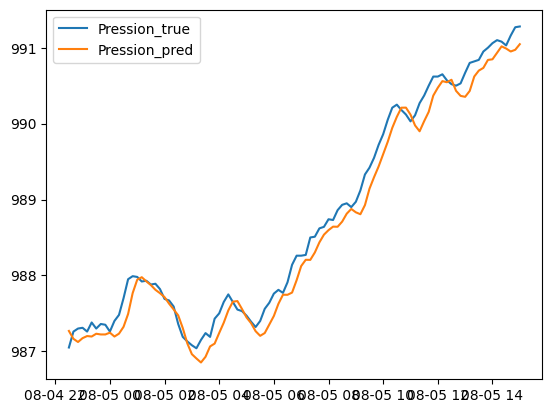

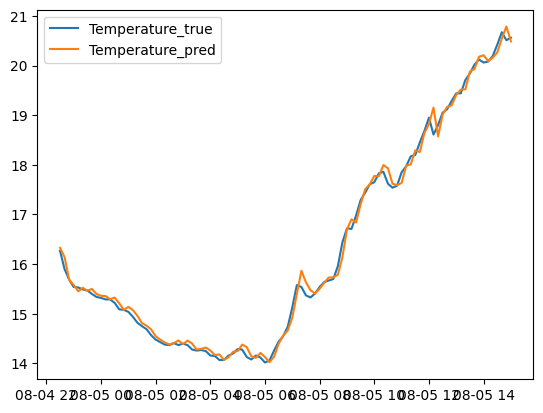

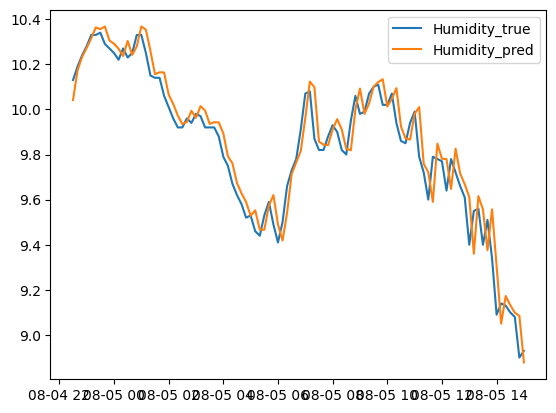

In [17]:
plot_predictions(model,X_test,y_test,0,100)

657/657 [==============================] - 1s 2ms/step


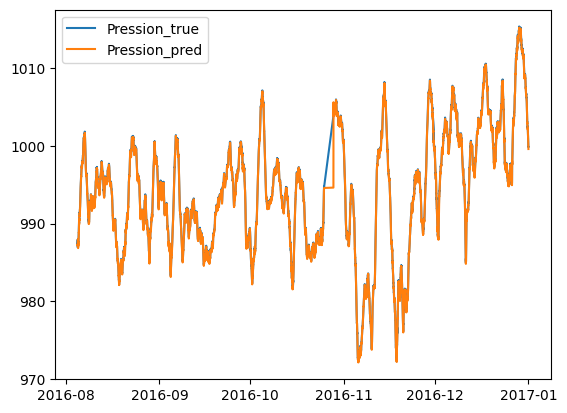

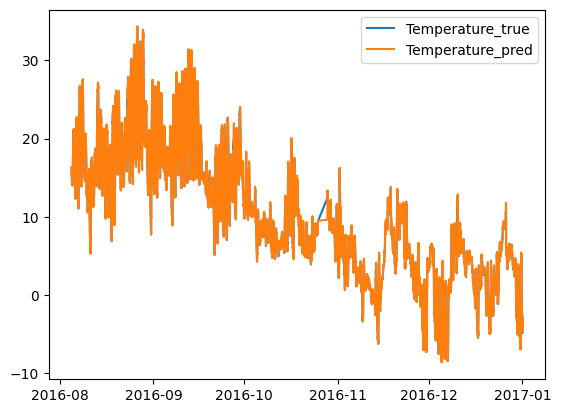

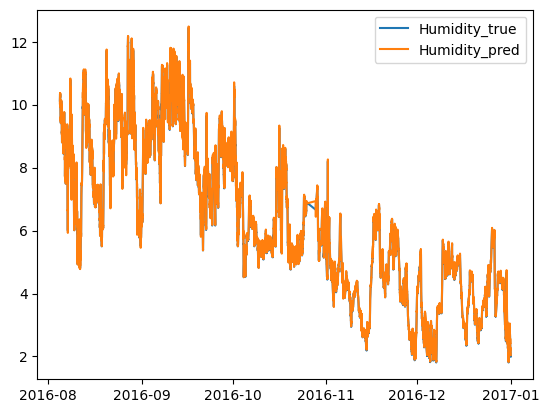

In [18]:
plot_predictions(model,X_test,y_test)